In [2]:
import seaborn as sbn
import pandas as pd
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Verilerin Yüklenmesi

In [3]:
veri=sbn.load_dataset("iris")
veri

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


# Ön İşleme Adımları

- AYKIRI GÖZLEM ANALİZİ

<AxesSubplot:xlabel='sepal_length'>

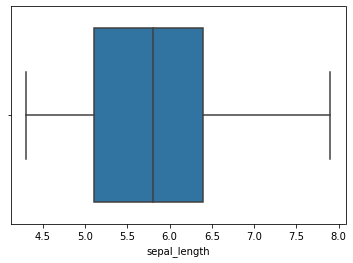

In [4]:
# Veri setindeki bağımsız değişken değerleri float olduğu için sadece onları çağırdık 
df=veri.select_dtypes(include=["float64"])
sepal_len=df["sepal_length"]
sbn.boxplot(x=sepal_len)

<AxesSubplot:xlabel='sepal_width'>

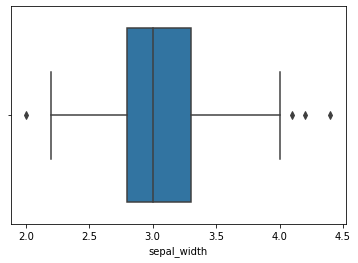

In [5]:
sepal_wid=df["sepal_width"]
sbn.boxplot(x=sepal_wid)

In [6]:
Q1=sepal_wid.quantile(0.25)
Q3=sepal_wid.quantile(0.75)
IQR=Q3-Q1

In [7]:
alt_sınır=Q1-1.5*IQR
ust_sınır=Q3+1.5*IQR
aykır_tf=(sepal_wid<alt_sınır)|((sepal_wid>ust_sınır))
sepal_wid[aykır_tf]

15    4.4
32    4.1
33    4.2
60    2.0
Name: sepal_width, dtype: float64

In [8]:
t_tf=sepal_wid[~((sepal_wid<(alt_sınır))|(sepal_wid>(ust_sınır)))]
t_tf.shape

(146,)

In [10]:
sepal_wid.mean()


3.057333333333334

In [12]:
yedek=veri.copy()
yedek.drop("sepal_width",axis=1,inplace=True)

In [18]:
sepal_wid[aykır_tf]=sepal_wid.mean()
a=pd.DataFrame(t_tf)
b=pd.DataFrame(sepal_wid[aykır_tf])
duz_veri=pd.concat([a, b], axis=0).sort_index() 
son_veri=pd.concat([yedek,duz_veri],axis=1)
son_veri=son_veri[["sepal_length","sepal_width","petal_length","petal_width","species"]]
dizim=[15,32,33,60]
son_veri["sepal_width"][dizim]

C:\Users\emre2\anaconda3\lib\site-packages\pandas\core\generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


15    3.040411
32    3.040411
33    3.040411
60    3.040411
Name: sepal_width, dtype: float64

- AYKIRI DEĞERLERİ ORTALAMA İLE DOLDURDUK

<AxesSubplot:xlabel='petal_length'>

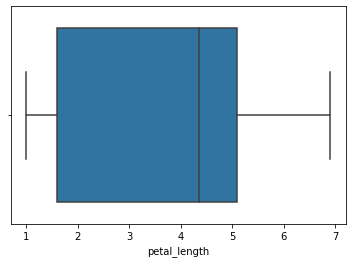

In [19]:
petal_len=df["petal_length"]
sbn.boxplot(x=petal_len)

<AxesSubplot:xlabel='petal_width'>

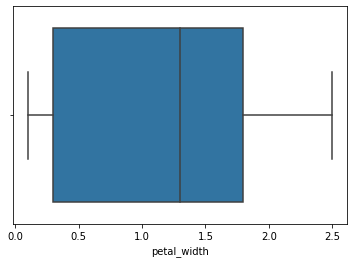

In [20]:
petal_wid=df["petal_width"]
sbn.boxplot(x=petal_wid)

In [ ]:
veri.corr()

- Korelasyon Matrisi ile yukarıda bağımsız değişkenlerin birbirleri arasında ki ilişkiyi görüyoruz.

In [ ]:
veri.describe().T

- Bağımsız değişkenler hakkında genel bilgilendirme yapılıyor

In [ ]:
veri.info()

- İnfo, değişkenlerin tipleri ve türlüleri hakkında bilgi veriyor. Tablodan anlaşılacağı gibi null değerimiz yok

# Bağımlı Kategorik Değişkenleri Numerice Çevireceğiz

In [22]:
tür=son_veri.iloc[:,-1].values
le=preprocessing.LabelEncoder()
tür=le.fit_transform(tür).reshape(150,1)

In [23]:
ohe=preprocessing.OneHotEncoder()
tür=ohe.fit_transform(tür).toarray()

In [25]:
türSon=pd.DataFrame(data=tür,index=range(150),columns=["setosa","versicolor","virginica"])
türSon.head()

,setosa,versicolor,virginica
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [26]:
y_veri=son_veri.iloc[:,0:4]
y_veri.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [29]:
birlesme=pd.concat([y_veri,türSon],axis=1)
birlesme.head()

,sepal_length,sepal_width,petal_length,petal_width,setosa,versicolor,virginica
0,5.1,3.5,1.4,0.2,1.0,0.0,0.0
1,4.9,3.0,1.4,0.2,1.0,0.0,0.0
2,4.7,3.2,1.3,0.2,1.0,0.0,0.0
3,4.6,3.1,1.5,0.2,1.0,0.0,0.0
4,5.0,3.6,1.4,0.2,1.0,0.0,0.0


In [30]:
# Bağımsız Değişkenler
x=birlesme.iloc[:,0:4].values
# Bağımlı Değişkenler
y=birlesme.iloc[:,4:].values 

# TEST/TRAİN

In [31]:
x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.30,random_state=0)

# Verilerin Olceklenmesi

In [32]:
sc=StandardScaler()
X_train = sc.fit_transform(x_train)
# Xtrainden öğrendiğini (fit) X_testte uygula
X_test = sc.transform(x_test)

# XGBOOST

In [33]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred=xgb.predict(X_test)

# RANDOM FOREST

In [34]:
rfc=RandomForestClassifier(n_estimators=12,criterion="entropy")
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)

# SVM

In [35]:
svm = OneVsRestClassifier(SVC(kernel = 'linear', decision_function_shape = 'ovo')).fit(X_train, y_train)
y_pred=svm.predict(X_test)

In [36]:
modeller=[xgb,rfc,svm]
for model in modeller:
    isimler = model.__class__.__name__
    y_pred = model.predict(X_test)
    dogruluk = accuracy_score(y_test, y_pred)
    precion=precision_score(y_test, y_pred,average='micro')
    cof=confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    roc=roc_auc_score(y_test, y_pred)
    r2=r2_score(y_test, y_pred)
    
    print("-"*26)
    print(isimler + ":" )
    print("Accuracy: {:.4%}".format(dogruluk))
    print("Precion Değeri: ")
    print(precion)
    print("Cofficient Değeri: ")
    print(cof)
    print("Roc Auc Değeri: ")
    print(roc)
    print("R2 Değeri: ")
    print(r2)

--------------------------
XGBClassifier:
Accuracy: 97.7778%
Precion Değeri: 
0.9777777777777777
Cofficient Değeri: 
[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
Roc Auc Değeri: 
0.9858387799564271
R2 Değeri: 
0.9290288505974781
--------------------------
RandomForestClassifier:
Accuracy: 95.5556%
Precion Değeri: 
0.9772727272727273
Cofficient Değeri: 
[[16  0  0]
 [ 0 17  1]
 [ 1  0 10]]
Roc Auc Değeri: 
0.970687264804912
R2 Değeri: 
0.8889218987258203
--------------------------
OneVsRestClassifier:
Accuracy: 66.6667%
Precion Değeri: 
0.9393939393939394
Cofficient Değeri: 
[[16  0  0]
 [13  4  1]
 [ 0  1 10]]
Roc Auc Değeri: 
0.8592955700798838
R2 Değeri: 
0.4969300851653793


# AYKIRI DEĞERLERİ ÇIKARMADAN ÖNCE Kİ HALİ

In [ ]:
-------------------------
XGBClassifier:
Accuracy: 95.5556%
Precion Değeri: 
0.9565217391304348
Cofficient Değeri: 
[[16  0  0]
 [ 0 17  1]
 [ 0  1 10]]
Roc Auc Değeri: 
0.9796659404502542
R2 Değeri: 
0.898164653066614
--------------------------
RandomForestClassifier:
Accuracy: 97.7778%
Precion Değeri: 
0.9777777777777777
Cofficient Değeri: 
[[16  0  0]
 [ 0 17  1]
 [ 0  0 11]]
Roc Auc Değeri: 
0.9858387799564271
R2 Değeri: 
0.9290288505974781
--------------------------
OneVsRestClassifier:
Accuracy: 66.6667%
Precion Değeri: 
0.9393939393939394
Cofficient Değeri: 
[[16  0  0]
 [13  4  1]
 [ 0  1 10]]
Roc Auc Değeri: 
0.8592955700798838
R2 Değeri: 
0.4969300851653793